# Segment Building Footprints in Zanzibar

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
import fastai
print(fastai.__version__)

1.0.28


## Load Data

In [25]:
path = Path('/storage/znz-segment/znz-train-z19-all-buffered')
path.ls()

[PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/.DS_Store'),
 PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/valid.txt'),
 PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/images-512'),
 PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/masks-512')]

In [26]:
path_lbl = path/'masks-512'
path_img = path/'images-512'

In [27]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
fnames[:3], lbl_names[:3] 

([PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/images-512/grid_036_19_319455_270721_img.jpg'),
  PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/images-512/grid_058_19_319438_270866_img.jpg'),
  PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/images-512/grid_001_19_319372_270499_img.jpg')],
 [PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/masks-512/grid_001_19_319373_270494_mask_buffered.png'),
  PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/masks-512/grid_029_corrected_19_319458_270686_mask_buffered.png'),
  PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/masks-512/grid_001_19_319370_270506_mask_buffered.png')])

In [28]:
len(fnames), len(lbl_names)

(2691, 2691)

In [29]:
get_y_fn = lambda x: path_lbl/f'{x.stem.split("_img")[0]}_mask_buffered.png'

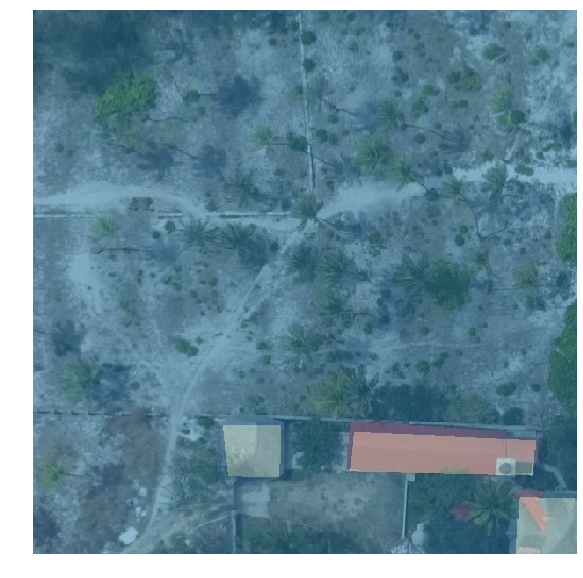

In [30]:
img_f = fnames[0]
img = open_image(img_f)
mask = open_mask(get_y_fn(img_f), div=True)

fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.5)

In [31]:
src_size = np.array(mask.shape[1:])
print(src_size)
mask.data

[512 512]


tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]]])

# Make DataBunch

In [32]:
size = src_size
bs=16

In [33]:
holdout_grids = ['_028_','_029_','_042_','_058_']
valid_idx = [i for i,o in enumerate(fnames) if any(c in str(o) for c in holdout_grids)]

In [34]:
codes = np.array(['Empty','Building'])

In [35]:
# overriding to set open_mask(fn, div=True), probably a better way to do this
# idea from https://forums.fast.ai/t/unet-binary-segmentation/29833/19

class SegmentationLabelList(ImageItemList):
    def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        self.classes,self.loss_func = classes,CrossEntropyFlat()
        self.c = len(self.classes)

    def new(self, items, classes=None, **kwargs):
        return self.__class__(items, ifnone(classes, self.classes), **kwargs)

    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(ImageItemList): _label_cls = SegmentationLabelList

In [36]:
src = (SegmentationItemList.from_folder(path_img)
        .split_by_idx(valid_idx)
        .label_from_func(get_y_fn, classes=codes))

In [37]:
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [38]:
data

ImageDataBunch;
Train: LabelList
y: SegmentationLabelList (2094 items)
[ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512)]...
Path: /storage/znz-segment/znz-train-z19-all-buffered/images-512
x: SegmentationItemList (2094 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: /storage/znz-segment/znz-train-z19-all-buffered/images-512;
Valid: LabelList
y: SegmentationLabelList (597 items)
[ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512)]...
Path: /storage/znz-segment/znz-train-z19-all-buffered/images-512
x: SegmentationItemList (597 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: /storage/znz-segment/znz-train-z19-all-buffered/images-512;
Test: None

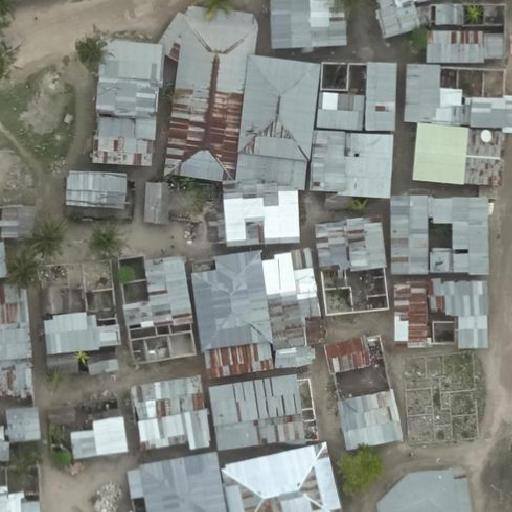

In [39]:
data.train_ds.x[1]

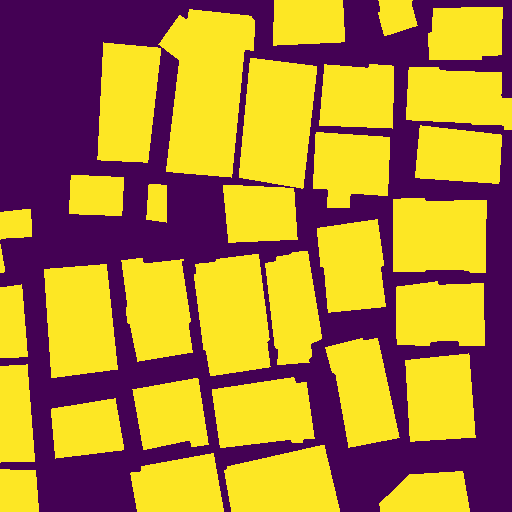

In [40]:
data.train_ds.y[1]

In [41]:
data.train_ds.y[1].data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]])

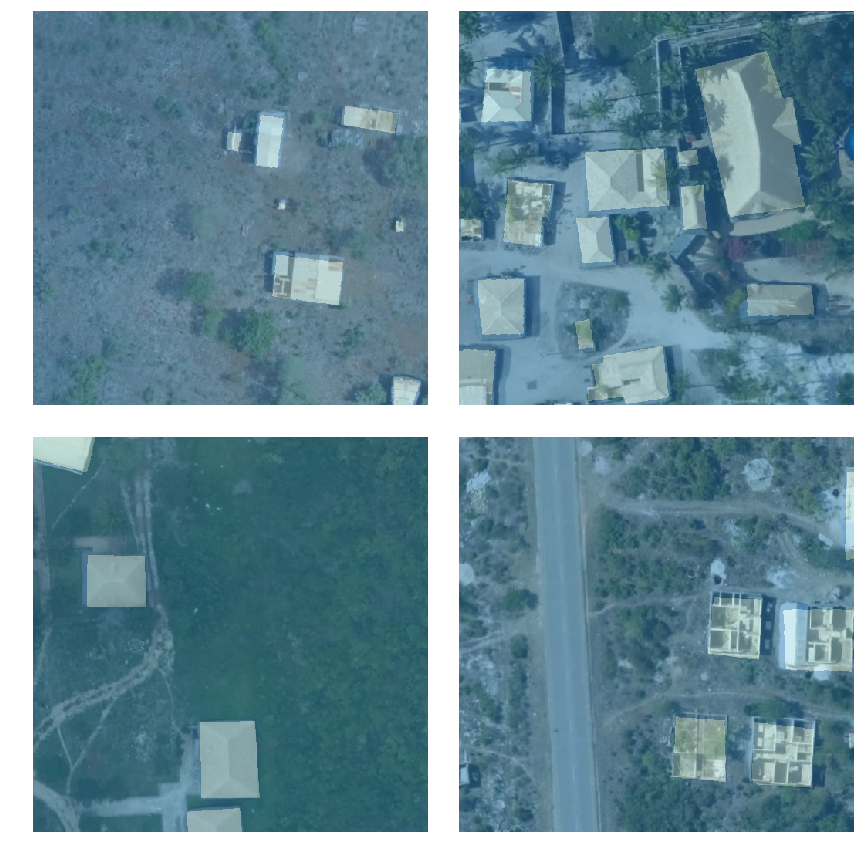

In [42]:
data.show_batch(2,figsize=(12,12))

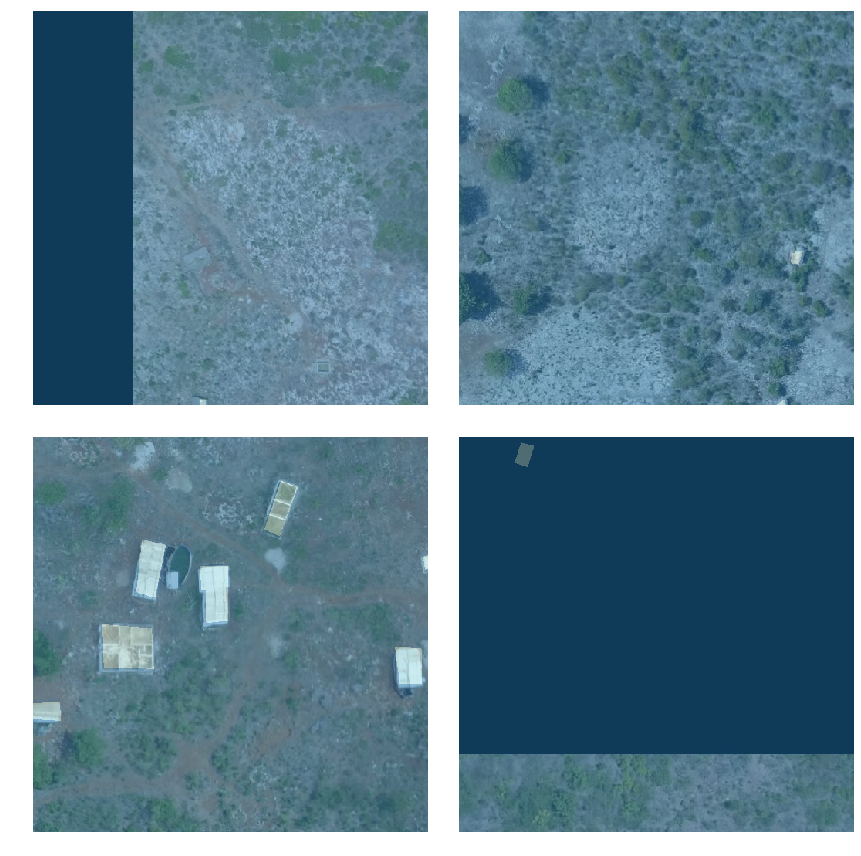

In [43]:
data.show_batch(2,figsize=(12,12), ds_type=DatasetType.Valid)

## Train Model (Resnet34)

In [44]:
iou = partial(dice, iou=True)
metrics = [iou, dice]

In [45]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 81367393.94it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


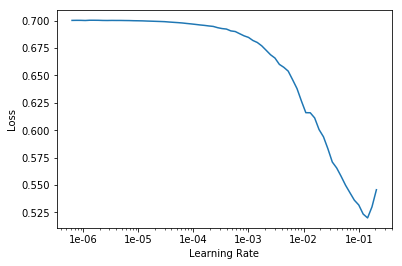

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
lr = 1e-3

In [27]:
learn.fit_one_cycle(10, max_lr=lr)

Total time: 10:31
epoch  train_loss  valid_loss  dice  dice        
1      0.464104    0.157809    0.642891  0.781625  (01:10)
2      0.175204    0.094988    0.691824  0.817218  (01:02)
3      0.117466    0.100732    0.611989  0.758397  (01:02)
4      0.109253    0.062978    0.707349  0.827677  (01:02)
5      0.092795    0.062255    0.689107  0.814713  (01:02)
6      0.093652    0.060794    0.721744  0.837669  (01:02)
7      0.081844    0.057130    0.725440  0.840171  (01:02)
8      0.076429    0.053636    0.731807  0.844303  (01:02)
9      0.074103    0.052719    0.736343  0.847382  (01:02)
10     0.071743    0.053197    0.733691  0.845619  (01:02)



In [28]:
learn.save('20181119-rn34unet-z19-stage1')

In [29]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


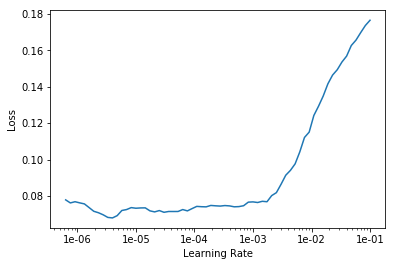

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,lr/5))

Total time: 11:33
epoch  train_loss  valid_loss  dice  dice        
1      0.075060    0.053479    0.730800  0.843607  (01:09)
2      0.071808    0.052855    0.738061  0.848650  (01:08)
3      0.076940    0.053453    0.735145  0.846635  (01:09)
4      0.072776    0.053501    0.725269  0.839781  (01:09)
5      0.069003    0.051816    0.741528  0.850891  (01:09)
6      0.069426    0.052269    0.736084  0.847013  (01:09)
7      0.065429    0.052343    0.739905  0.849711  (01:09)
8      0.062942    0.052162    0.738256  0.848678  (01:09)
9      0.063502    0.051691    0.740793  0.850347  (01:09)
10     0.062983    0.051699    0.740807  0.850377  (01:09)



In [32]:
learn.save('20181119-rn34unet-z19-stage2')

In [42]:
learn.load('20181119-rn34unet-z19-stage2')

Learner(data=ImageDataBunch;
Train: LabelList
y: SegmentationLabelList (2094 items)
[ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512)]...
Path: /storage/znz-segment/znz-train-z19-all-buffered/images-512
x: SegmentationItemList (2094 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: /storage/znz-segment/znz-train-z19-all-buffered/images-512;
Valid: LabelList
y: SegmentationLabelList (597 items)
[ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512)]...
Path: /storage/znz-segment/znz-train-z19-all-buffered/images-512
x: SegmentationItemList (597 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: /storage/znz-segment/znz-train-z19-all-buffered/images-512;
Test: None, model=Dyn

In [43]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


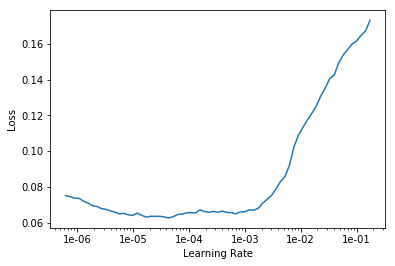

In [44]:
learn.lr_find()
learn.recorder.plot()

In [39]:
def acc_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.view(n,2,-1).argmax(dim=1)
    return (input==targs).float().mean()

In [52]:
learn.metrics = [acc_fixed, iou, dice]

In [45]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-3))

Total time: 11:28
epoch  train_loss  valid_loss  acc_fixed  dice  dice        
1      0.063512    0.056152    0.980237   0.736439  0.847582  (01:09)
2      0.077498    0.058126    0.979286   0.727058  0.841235  (01:09)
3      0.074409    0.063936    0.978575   0.687105  0.813410  (01:09)
4      0.073145    0.110138    0.980376   0.735875  0.846963  (01:08)
5      0.073402    0.053441    0.981319   0.734273  0.845944  (01:08)
6      0.067226    0.065212    0.980615   0.736327  0.847266  (01:08)
7      0.067072    0.053914    0.981336   0.737691  0.848132  (01:08)
8      0.064557    0.050410    0.981674   0.744677  0.852916  (01:08)
9      0.058899    0.050519    0.981679   0.742199  0.851311  (01:08)
10     0.058565    0.050807    0.981637   0.744698  0.852914  (01:08)



In [53]:
learn.save('20181119-rn34unet-z19-stage2_2')

In [54]:
learn.model.train()

DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [55]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-3))

Total time: 11:25
epoch  train_loss  valid_loss  acc_fixed  dice  dice        
1      0.058651    0.051996    0.981415   0.733266  0.845272  (01:08)
2      0.064079    0.050830    0.981654   0.748101  0.855320  (01:08)
3      0.065636    0.086810    0.981515   0.744395  0.852875  (01:08)
4      0.064190    0.053806    0.981091   0.728782  0.842140  (01:08)
5      0.066101    0.052692    0.981390   0.739744  0.849592  (01:08)
6      0.061179    0.050355    0.981630   0.746352  0.853955  (01:08)
7      0.059329    0.051607    0.981003   0.746103  0.853980  (01:08)
8      0.057352    0.052356    0.981855   0.747775  0.854927  (01:08)
9      0.054226    0.049756    0.982015   0.749026  0.855763  (01:08)
10     0.054903    0.049618    0.981975   0.749988  0.856428  (01:08)



In [56]:
learn.save('20181119-rn34unet-z19-stage2_3')

# See Predictions

In [48]:
learn.load('20181119-rn34unet-z19-stage2_3')
learn.model.eval()

DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [49]:
outputs = learn.pred_batch()

In [50]:
outputs.shape

torch.Size([24, 2, 512, 512])

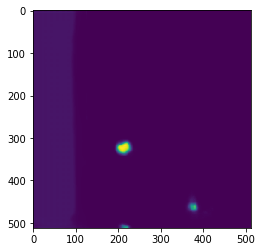

In [51]:
plt.imshow((to_np(outputs[0][1])))

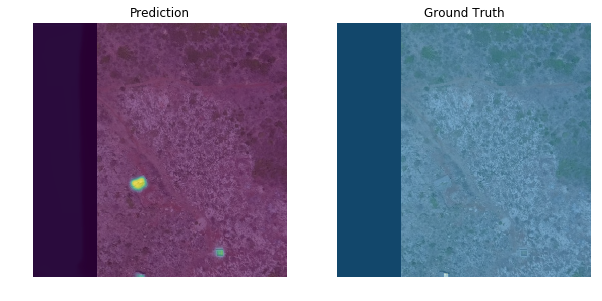

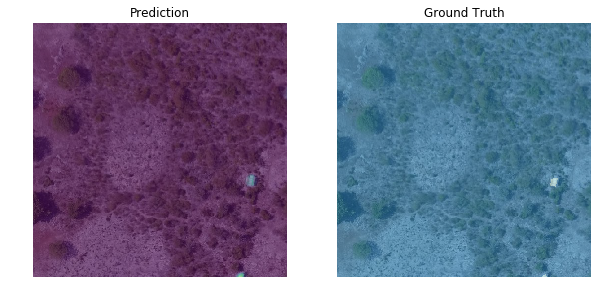

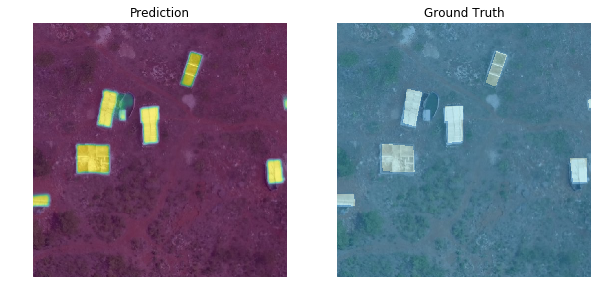

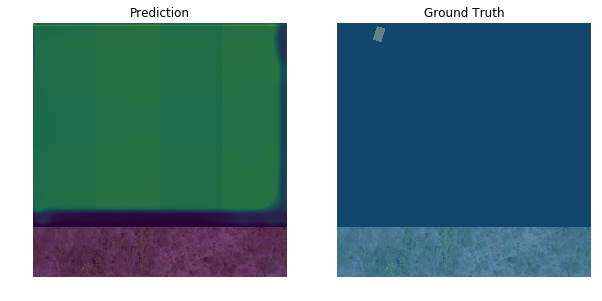

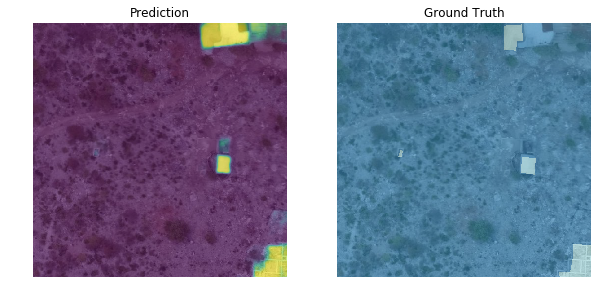

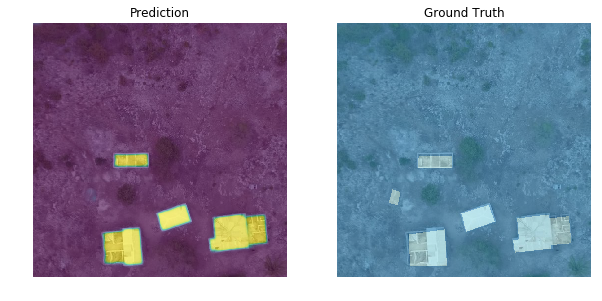

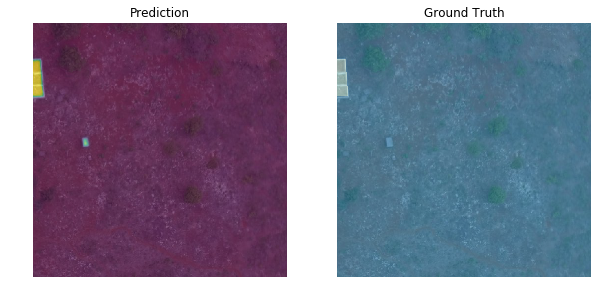

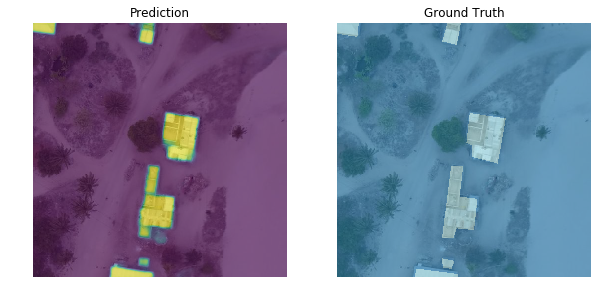

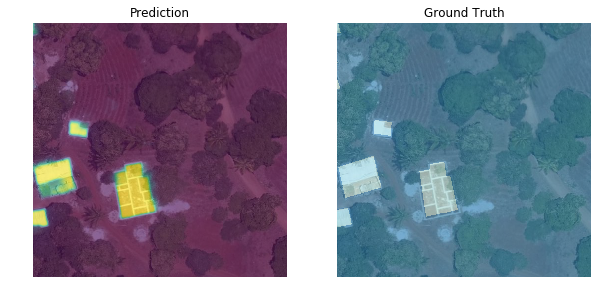

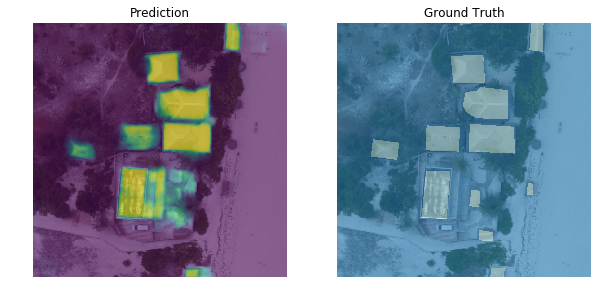

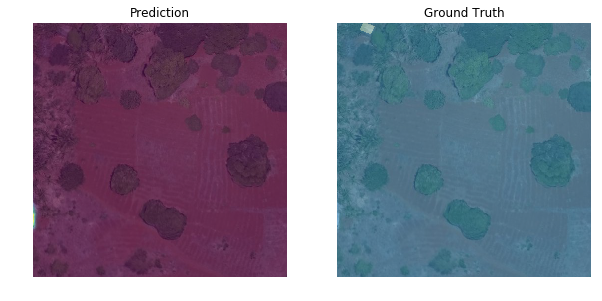

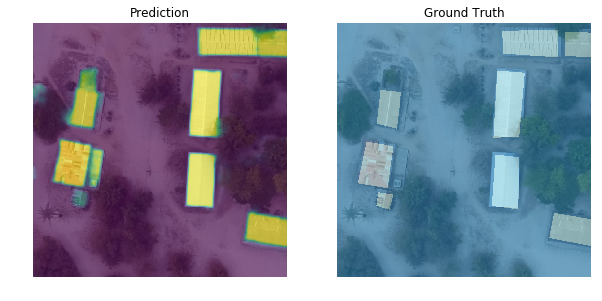

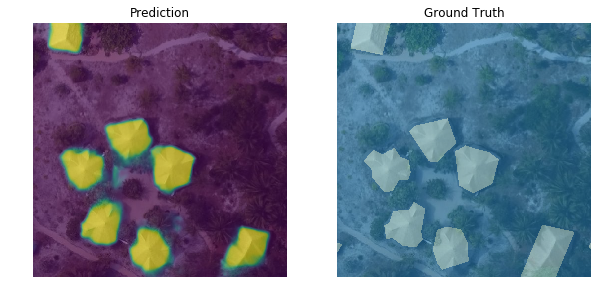

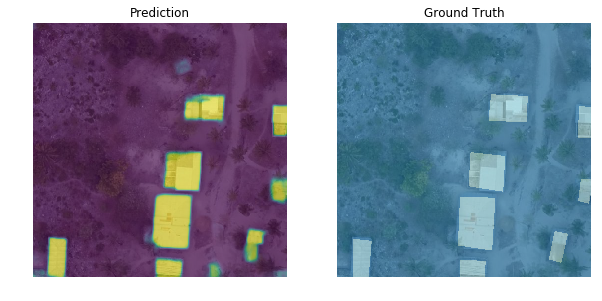

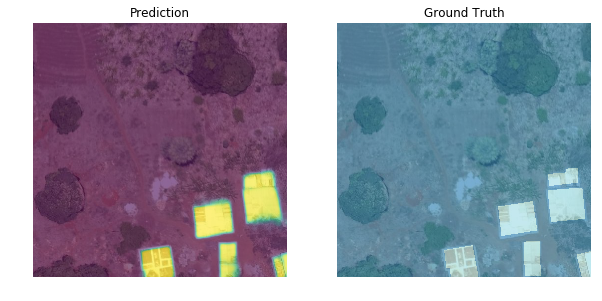

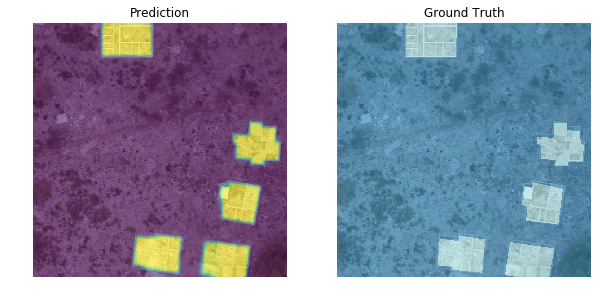

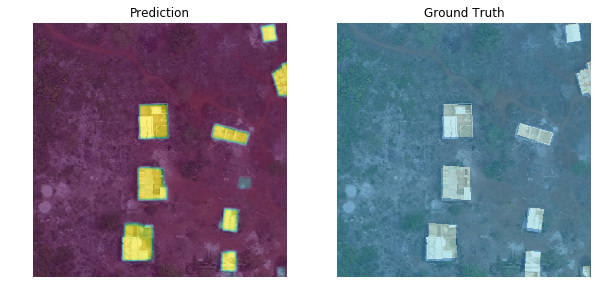

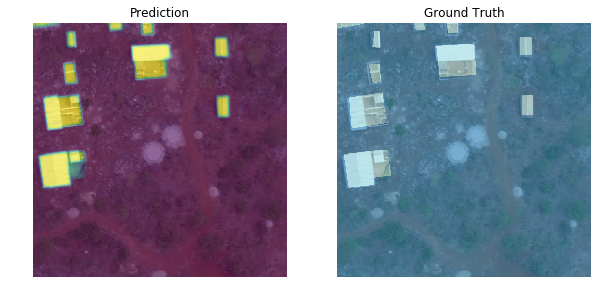

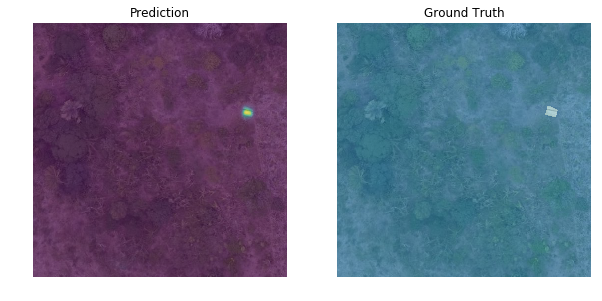

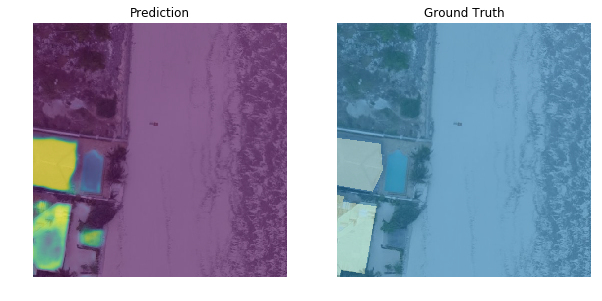

In [55]:
for i in range(20):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[i][1])), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()